# Regression

## Objectives

*   Fit and evaluate a Regression model to predict SalePrice.


## Inputs

* outputs/datasets/cleaned/CleanedHousePricing.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict SalePrice
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/HeritageHousing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/HeritageHousing'

---

# Load Data

In [5]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/CleanedHousePricing.csv")
print(df.shape)
df.head(3)


(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,0,706,0,150,548,0,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,1,978,1,284,460,0,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,2,486,0,434,608,0,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


# MP Pipeline: Regressor

## Create ML pipeline

In [490]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        #("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
           #                                          variables=['KitchenQual', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),

        #("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


Custom Class for hyperparameter optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [491]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [492]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

In [493]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [494]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.805591,0.874444,0.075006
2,RandomForestRegressor,0.632989,0.788582,0.85964,0.081285
0,LinearRegression,0.715522,0.786632,0.819273,0.037851
5,GradientBoostingRegressor,0.635656,0.754929,0.850056,0.085652
6,XGBRegressor,0.637822,0.750406,0.833898,0.070693
4,AdaBoostRegressor,0.664449,0.72018,0.767557,0.041191
1,DecisionTreeRegressor,0.495511,0.636877,0.760656,0.087565


Define model and parameters, for Extensive Search

In [495]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [7],
        'model__max_depth': [7],
        'model__min_samples_split': [7],
    }
}


Extensive GridSearch CV

In [496]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=6)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 6 folds for each of 1 candidates, totalling 6 fits


Check results

In [497]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.615994,0.781671,0.846837,0.082149,7,7,7


Check the best model

In [498]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [499]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 7,
 'model__min_samples_split': 7,
 'model__n_estimators': 7}

Define the best regressor, based on search

In [500]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline


Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=7, min_samples_split=7,
                                     n_estimators=7, random_state=0))])

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageArea']


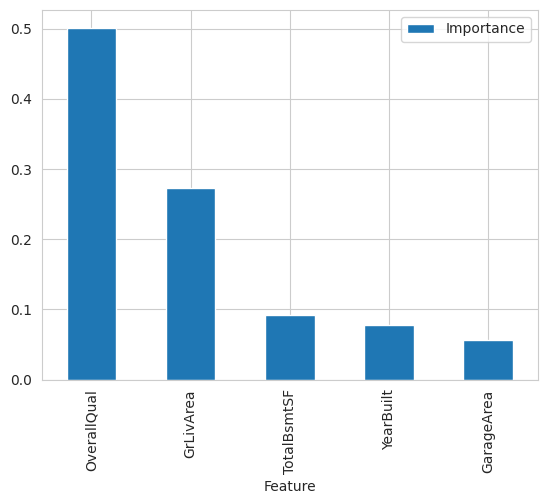

In [505]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [502]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.901
Mean Absolute Error: 17614.303
Mean Squared Error: 610931610.731
Root Mean Squared Error: 24717.031


* Test Set
R2 Score: 0.86
Mean Absolute Error: 19424.068
Mean Squared Error: 966526052.289
Root Mean Squared Error: 31089.002




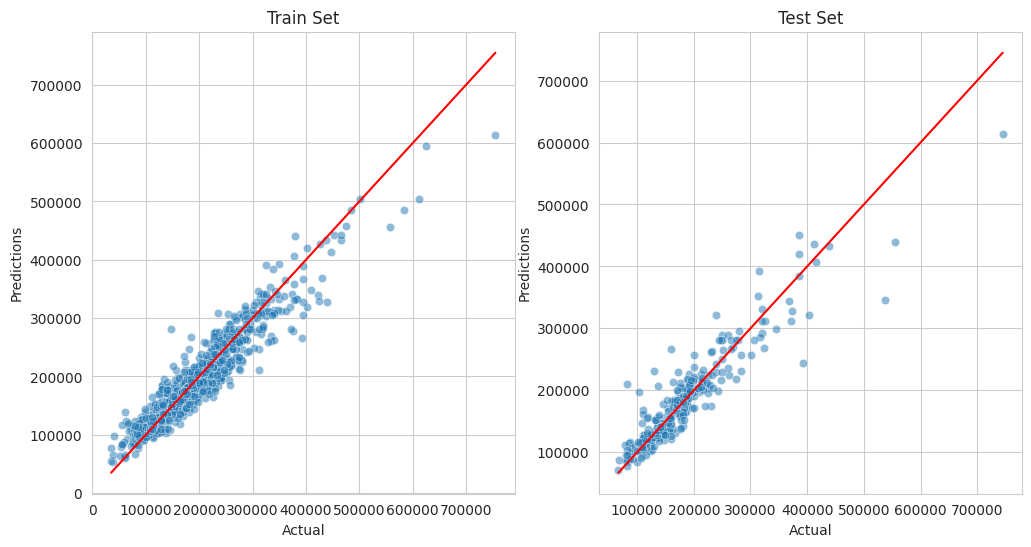

In [503]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Let's explore potential values for PCA n_components.

In [458]:
pipeline = PipelineOptimization(model=ExtraTreesRegressor())
pipeline_pca = Pipeline(pipeline.steps[:2])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



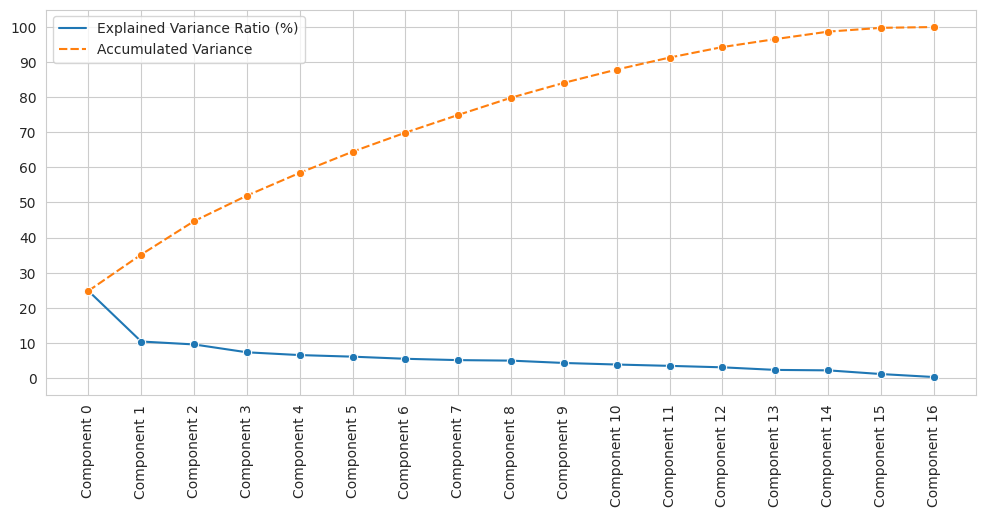

In [459]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 15 components explain 98.69% of the data 



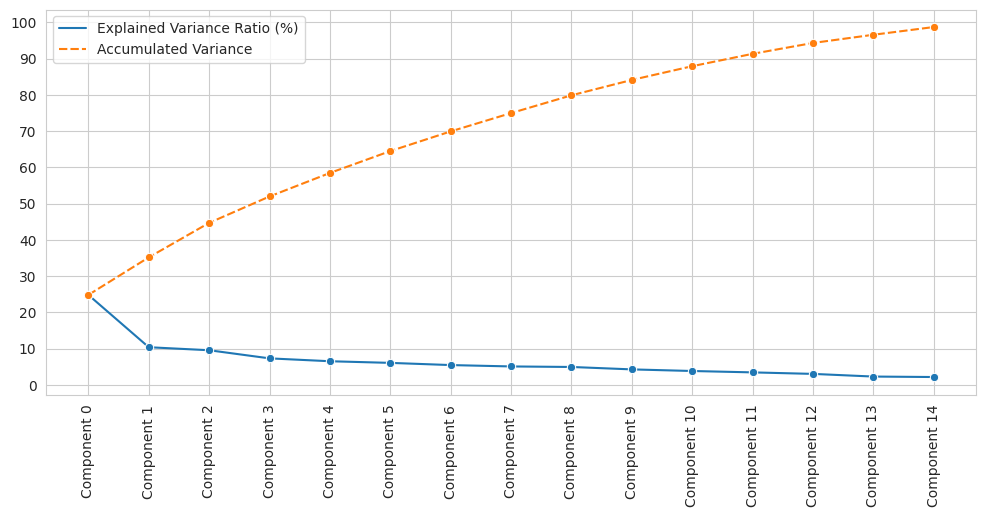

In [460]:
n_components = 15
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [461]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=10, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [51]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Use standard hyperparameters to find the most suitable model.

In [447]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [462]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [463]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.685958,0.773942,0.858444,0.061644
2,RandomForestRegressor,0.671846,0.768888,0.842588,0.059385
0,LinearRegression,0.695496,0.758206,0.820562,0.040743
5,GradientBoostingRegressor,0.65424,0.749305,0.834575,0.069779
6,XGBRegressor,0.556448,0.72097,0.824729,0.089658
4,AdaBoostRegressor,0.63274,0.706688,0.780606,0.051497
1,DecisionTreeRegressor,0.314593,0.544123,0.713396,0.13725


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [479]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    
}


# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [7],
        'model__max_depth': [7],
        'model__min_samples_split': [7],
    }
}


Extensive GridSearch CV

In [480]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [481]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.661983,0.739584,0.811381,0.060174,7,7,7


Check the best model

In [482]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [483]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 7,
 'model__min_samples_split': 7,
 'model__n_estimators': 7}

Define the best regressor

In [518]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=7, min_samples_split=7,
                                     n_estimators=7, random_state=0))])

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.872
Mean Absolute Error: 19269.432
Mean Squared Error: 787070497.29
Root Mean Squared Error: 28054.777


* Test Set
R2 Score: 0.813
Mean Absolute Error: 22435.205
Mean Squared Error: 1289436562.656
Root Mean Squared Error: 35908.725




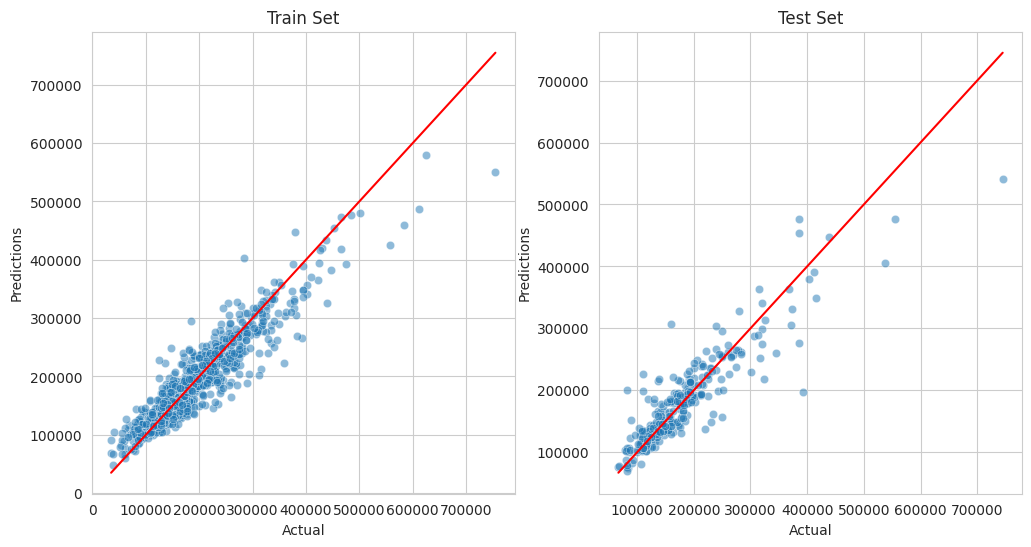

In [485]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Which pipeline to choose?

We fitted 2 pipelines:
* Regression 
* Regression with PCA


Regression 
- Train: 0.901 R2 Score
- Test: 0.86 R2 Score

Regression with PCA
- Train: 0.872 R2 Score
- Test: 0.813 R2 Score

The both regressor pipelines did reach above the expected performance threshold (0.75 R2 score) for the train and test set.
* The regression pipeline without PCA performed better with a higher R2 score and less decrees on the test sets R2 Score

However in the process i tried excluding the numerical transformers from the pipeline because it seemed like it was overfitting all models tested and the model performance got much better without than with the transformers. 

# Refit pipeline with best features

Subset Best Features

In [507]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921


# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [508]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [509]:
X_train.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921
817,857,1689,8,1568,2002
302,843,1541,7,1541,2001


In [510]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [511]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [512]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [513]:
X_test.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
529,484,2515,6,2035,1957
491,240,1578,6,806,1941
459,352,1203,5,709,1950
279,505,2022,7,1160,1977
655,264,1092,6,525,1971


In [514]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [515]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [516]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting SalePrice

In [523]:
pipeline = best_regressor_pipeline
pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=7, min_samples_split=7,
                                     n_estimators=7, random_state=0))])

In [524]:
joblib.dump(value=pipeline, filename=f"{file_path}/pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v1/pipeline.pkl']

## Feature importance plot

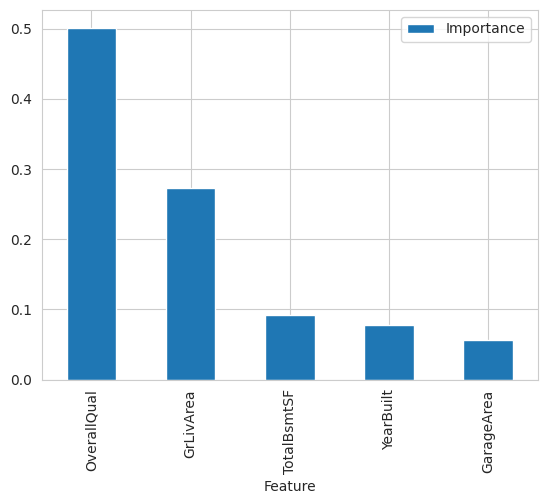

In [525]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

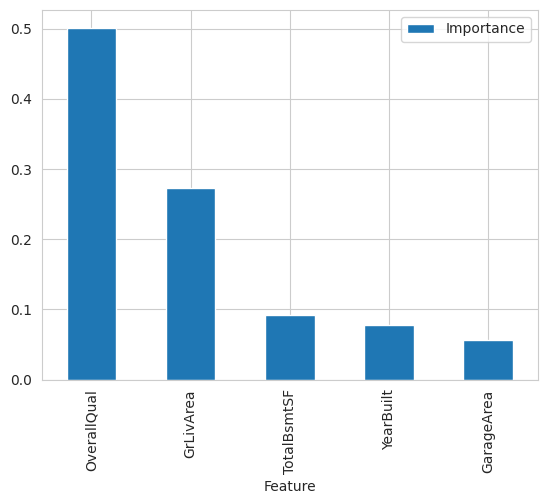

In [526]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---